## 0. Understanding the Problem

The process of classifying the authors for a given text is called authorship attribution. Each author writes about different topics and has their own style of writing (author fingerprint) which allows for the identification. Applications of this kind of model include plaigarism detection and resolving the disputed authorship. 

In the dataset given there are 2 columns: Author and Text
This makes it a supervised learning problem since there is data and a assigned label  to each text. 

In the problem, the cost of false positive and false negatives both carry significant consequences. Therefore, a good model should have a balance of sensitivity and specificity. F1-score would be the ideal metric for the model evaluation


### Aim of notebook (part 1 / 2)
This notebook is part 1 of 2 notebooks, it aims to clean the textual data and perform feature engineering on the data. Specifically, meta features will be created from the text data (features that describe the structure of the text data).

## 1. Installing and Importing Packages

In [1]:
# %pip install openpyxl --upgrade
# %pip install textstat

In [2]:
import re
import pandas as pd
from pprint import pprint
import numpy as np
import seaborn as sns
import string
from nltk.corpus import stopwords
from nltk import bigrams, trigrams, FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import MWETokenizer
import matplotlib.pyplot as plt
import contractions
import textstat
from nltk.tokenize import word_tokenize
from collections import Counter
import warnings
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
warnings.filterwarnings("ignore")
sns.set_style("darkgrid")
palette = "cool"

## 2. Data Understanding

In [3]:
df_train = pd.read_excel("Assignment_Data/Data.xlsx")

df_train.head()

,Text,Author
0,Scoring in PROC DISCRIM is as easy as validati...,AM
1,"In the GLM procedure, you may have used LSMEAN...",AM
2,"The first problem, accuracy of the data file, ...",AM
3,If the homogeneity of covariance matrices assu...,AM
4,"With a CONTRAST statement, you specify L, in t...",AM


In [4]:
df_train.shape

(1922, 2)

In [5]:
df_train.info()
# no null values in the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1922 entries, 0 to 1921
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    1922 non-null   object
 1   Author  1922 non-null   object
dtypes: object(2)
memory usage: 30.2+ KB


In [6]:
# check for duplicates in the text data 
duplicate_data = df_train.duplicated(keep="first")

print(duplicate_data.sum(), "duplicate rows are present within the data")


display(df_train[duplicate_data].sort_values(by="Text").head(8))

1106 duplicate rows are present within the data


,Text,Author
1367,"%distribution(data=&data,out=&report_name,cont...",DM
1419,"%distribution(data=&data,out=&report_name,cont...",DM
1414,"%generate_grouping(from=work.profile_codes,val...",DM
1243,"%generate_grouping(from=work.profile_codes,val...",DM
1362,*\tTemporal infidelity occurs when model input...,DM
1370,*\tTemporal infidelity occurs when model input...,DM
248,*\texamining group differences on predictor va...,AM
44,*\texamining group differences on predictor va...,AM


In [7]:
# remove the duplicate rows within the dataset
df_train.drop_duplicates(inplace=True)
display(df_train.shape)

(816, 2)

<div class="alert alert-info" role="alert">
    There's quite a lot of duplicated rows present. These will be unhelpful for training the model and need to be removed.
</div>

## 3. Feature Engineering

In [8]:
df_train["text_length"] = df_train.Text.apply(len)
df_train.head()

,Text,Author,text_length
0,Scoring in PROC DISCRIM is as easy as validati...,AM,215
1,"In the GLM procedure, you may have used LSMEAN...",AM,782
2,"The first problem, accuracy of the data file, ...",AM,990
3,If the homogeneity of covariance matrices assu...,AM,934
4,"With a CONTRAST statement, you specify L, in t...",AM,1490


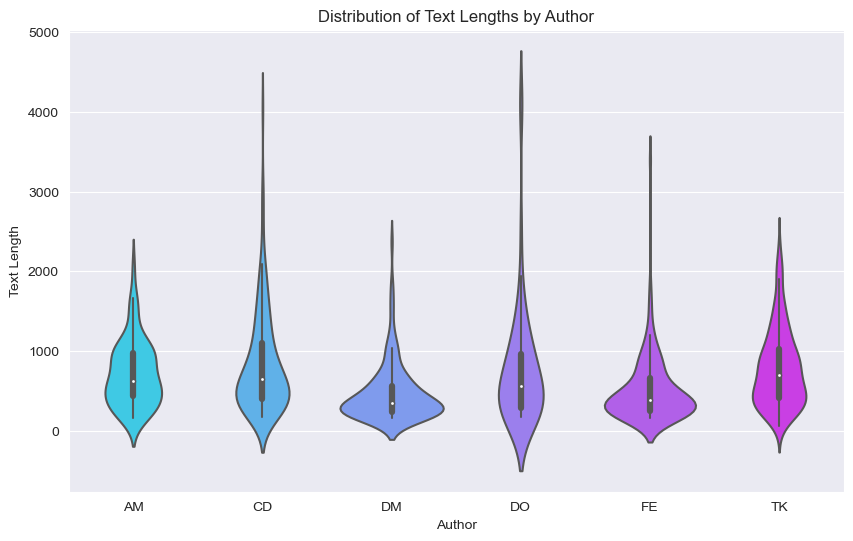

In [9]:
plt.figure(figsize=(10, 6))
ax = sns.violinplot(data=df_train, x="Author", y="text_length", element="poly", palette=palette);
ax.set_title('Distribution of Text Lengths by Author');
ax.set_ylabel('Text Length');

<div class="alert alert-info" role="alert">
    --> Shows that some authors like AM and DM tend to write shorter texts. This could be a distinguishing feature in the model.<br>
    --> Looks like majority of the text lengths are around 400 - 500 characters with slight differences. <br>
    --> This is not a strong feature in the classification, other features need to be looked at.
</div>

In [10]:
# function to count the number of words inside a sentence
def word_counter(sent):
    return len(sent.split(" "))

df_train["word_count"] = df_train["Text"].apply(word_counter)

df_train.head()

,Text,Author,text_length,word_count
0,Scoring in PROC DISCRIM is as easy as validati...,AM,215,37
1,"In the GLM procedure, you may have used LSMEAN...",AM,782,129
2,"The first problem, accuracy of the data file, ...",AM,990,159
3,If the homogeneity of covariance matrices assu...,AM,934,146
4,"With a CONTRAST statement, you specify L, in t...",AM,1490,247


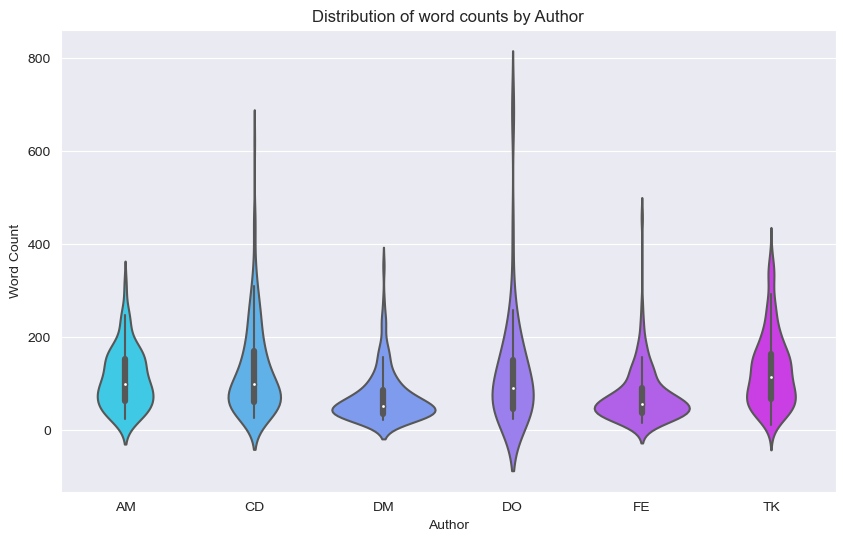

In [11]:
plt.figure(figsize=(10, 6))
ax = sns.violinplot(data=df_train, x="Author", y="word_count", element="poly", palette=palette);
ax.set_title('Distribution of word counts by Author');
ax.set_ylabel('Word Count');

<div class="alert alert-info" role="alert">
    --> Both word count and text length are highly correlated features. 
</div>

In [12]:
# getting the average word length

def avg_word_length(sent): 
    sent_len = len(sent.split(" "))
    return sum([len(wrd)  for wrd in sent]) / sent_len

df_train["avg_word_length"] = df_train["Text"].apply(avg_word_length)

df_train.head()

,Text,Author,text_length,word_count,avg_word_length
0,Scoring in PROC DISCRIM is as easy as validati...,AM,215,37,5.810811
1,"In the GLM procedure, you may have used LSMEAN...",AM,782,129,6.062016
2,"The first problem, accuracy of the data file, ...",AM,990,159,6.226415
3,If the homogeneity of covariance matrices assu...,AM,934,146,6.397260
4,"With a CONTRAST statement, you specify L, in t...",AM,1490,247,6.032389


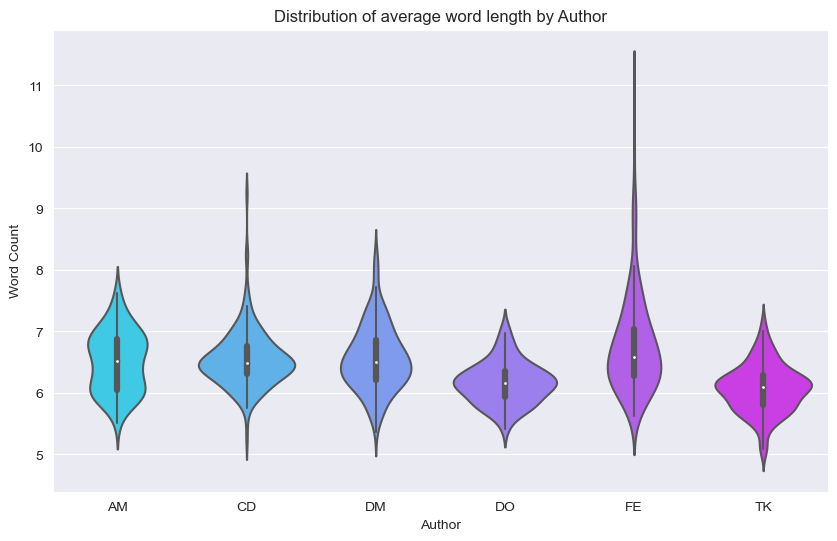

In [13]:
plt.figure(figsize=(10, 6))
ax = sns.violinplot(data=df_train, x="Author", y="avg_word_length", element="poly", palette=palette);
ax.set_title('Distribution of average word length by Author');
ax.set_ylabel('Word Count');

<div class="alert alert-info" role="alert">
    --> This can be a good distinguishing feature since each autho has different average word lengths.<br>
    --> Presence of outliers in author texts like FE indicates the usage of unique vocabulary.
</div>

In [14]:
# # adding a type-token ratio feature to check the lexical richness of the text, it is measured by looking at the ratio of the unique tokens to the total number of tokens used within the text. 

# # the aim is to look at the lexical richness of each author's texts by grouping by the author name.

def text_tokenizer(sent):
    lemmatizer = WordNetLemmatizer()
    sent = sent.lower() # convert the text to lowercase
    tokens = re.split(r'\W+', sent) # split text based on non word characters
    clean_tokens = [lemmatizer.lemmatize(i) for i in tokens if i not in string.punctuation or not i.isdigit()] # removing number, punctuation and lemmatizing the text
    clean_tokens_no_stopwords = [i for i in clean_tokens if i not in stopwords.words('english')]
    return clean_tokens_no_stopwords
    

def calculate_ttr(text):
    tokens = text_tokenizer(text.lower())
    types = set(tokens)
    return len(types) / len(tokens) if tokens else 0

df_train['type_to_token_ratio'] = df_train['Text'].apply(calculate_ttr)

df_train[['Author', 'Text', 'type_to_token_ratio']].head()

,Author,Text,type_to_token_ratio
0,AM,Scoring in PROC DISCRIM is as easy as validati...,0.840000
1,AM,"In the GLM procedure, you may have used LSMEAN...",0.661972
2,AM,"The first problem, accuracy of the data file, ...",0.712766
3,AM,If the homogeneity of covariance matrices assu...,0.604938
4,AM,"With a CONTRAST statement, you specify L, in t...",0.488372


In [15]:
# looking at the row with the smallest type to token ratio. 
small_ttt = df_train["type_to_token_ratio"].argmin()
print(f"Text with the smallest lexical richness by {df_train.iloc[small_ttt].Author}: ")
print(df_train.iloc[small_ttt].Text)

print("\n\n\n")

large_ttt = df_train["type_to_token_ratio"].argmax()
print(f"Text with the largest lexical richness by {df_train.iloc[large_ttt].Author}: ")
print(df_train.iloc[large_ttt].Text)

Text with the smallest lexical richness by CD: 
The LOGISTIC procedure enables you to specify whether model hierarchy is to be preserved, how model hierarchy is applied, and whether a single effect or multiple effects can be moved in a single step. Model hierarchy refers to the requirement that for any effect in the model, all effects it contains must also be in the model. For example, in order for the interaction A*B to enter the model, the main effects A and B must be in the model. Model hierarchy is desirable because models that are hierarchically well formulated have inferences that are invariant to the coding you choose for your predictor variables (Kleinbaum, Kupper, and Muller 1988). If the model is not hierarchically well formulated, then the tests for the lower order terms will depend on the coding (reference versus effect coding for categorical variables). The HIERARCHY= option specifies whether hierarchy is maintained and whether a single effect or multiple effects are allow

<div class="alert alert-info" role="alert">
    --> First text seems to be of more detailed and explanatory nature while the second is of a summary or conclusive type. <br>
    --> Both texts are written by the same author which shows the author's adaptability in terms of writing style (writing more varied concise words and in depth, writing of repeated technical terms).
</div>

In [16]:
df_train["punctuations_count"] = df_train['Text'].apply(lambda x: len([i for i in str(x) if i in string.punctuation]))

df_train.head()

# initially i looked at the number of commas and exclamation marks counts individually, however after looking at the topics that each of the author was talking about I realised that they were not talking about very subjective topics, so it was not necessary to collect those features. Instead I grouped all the punctuation counts together, which was more efficient as well since lesser features is better.

,Text,Author,text_length,word_count,avg_word_length,type_to_token_ratio,punctuations_count
0,Scoring in PROC DISCRIM is as easy as validati...,AM,215,37,5.810811,0.840000,5
1,"In the GLM procedure, you may have used LSMEAN...",AM,782,129,6.062016,0.661972,11
2,"The first problem, accuracy of the data file, ...",AM,990,159,6.226415,0.712766,19
3,If the homogeneity of covariance matrices assu...,AM,934,146,6.397260,0.604938,17
4,"With a CONTRAST statement, you specify L, in t...",AM,1490,247,6.032389,0.488372,29


In [17]:
def avg_sentence_length(txt):
    sents = re.split(r'[.!?]+', txt)
    sents = [i.strip() for i in sents if i.strip()]
    word_counts = [len(i.split()) for i in sents]

    if len(word_counts) > 0:
        return sum(word_counts) / len(word_counts)
    else:
        return 0
    
df_train['avg_sentence_length'] = df_train['Text'].apply(avg_sentence_length)

In [18]:
df_train.head()

,Text,Author,text_length,word_count,avg_word_length,type_to_token_ratio,punctuations_count,avg_sentence_length
0,Scoring in PROC DISCRIM is as easy as validati...,AM,215,37,5.810811,0.840000,5,12.333333
1,"In the GLM procedure, you may have used LSMEAN...",AM,782,129,6.062016,0.661972,11,18.428571
2,"The first problem, accuracy of the data file, ...",AM,990,159,6.226415,0.712766,19,16.000000
3,If the homogeneity of covariance matrices assu...,AM,934,146,6.397260,0.604938,17,18.250000
4,"With a CONTRAST statement, you specify L, in t...",AM,1490,247,6.032389,0.488372,29,15.687500


In [19]:
import spacy

nlp = spacy.load("en_core_web_sm") # spacy english model

def pos_proportions(text, pos_tag):
    doc = nlp(text)
    pos_counts = 0
    total_words = 0
    for token in doc:
        if token.is_alpha:
            total_words += 1
        if token.pos_ == pos_tag:
            pos_counts += 1
    return pos_counts / total_words if total_words > 0 else 0


# counting proportion of words which are nouns
df_train['POS_Nouns'] = df_train['Text'].apply(lambda x: pos_proportions(x, "NOUN"))
# counting proporiton of words which are everbs
df_train['POS_Verbs'] = df_train['Text'].apply(lambda x: pos_proportions(x, "VERB"))


df_train.head()

,Text,Author,text_length,word_count,avg_word_length,type_to_token_ratio,punctuations_count,avg_sentence_length,POS_Nouns,POS_Verbs
0,Scoring in PROC DISCRIM is as easy as validati...,AM,215,37,5.810811,0.840000,5,12.333333,0.305556,0.166667
1,"In the GLM procedure, you may have used LSMEAN...",AM,782,129,6.062016,0.661972,11,18.428571,0.286822,0.093023
2,"The first problem, accuracy of the data file, ...",AM,990,159,6.226415,0.712766,19,16.000000,0.234177,0.158228
3,If the homogeneity of covariance matrices assu...,AM,934,146,6.397260,0.604938,17,18.250000,0.312925,0.081633
4,"With a CONTRAST statement, you specify L, in t...",AM,1490,247,6.032389,0.488372,29,15.687500,0.282869,0.127490


In [20]:
def flesch_reading_score(text):
    return textstat.flesch_reading_ease(text)


df_train['flesch_reading_score'] = df_train['Text'].apply(flesch_reading_score)

df_train.head()

,Text,Author,text_length,word_count,avg_word_length,type_to_token_ratio,punctuations_count,avg_sentence_length,POS_Nouns,POS_Verbs,flesch_reading_score
0,Scoring in PROC DISCRIM is as easy as validati...,AM,215,37,5.810811,0.840000,5,12.333333,0.305556,0.166667,58.99
1,"In the GLM procedure, you may have used LSMEAN...",AM,782,129,6.062016,0.661972,11,18.428571,0.286822,0.093023,52.80
2,"The first problem, accuracy of the data file, ...",AM,990,159,6.226415,0.712766,19,16.000000,0.234177,0.158228,46.88
3,If the homogeneity of covariance matrices assu...,AM,934,146,6.397260,0.604938,17,18.250000,0.312925,0.081633,44.44
4,"With a CONTRAST statement, you specify L, in t...",AM,1490,247,6.032389,0.488372,29,15.687500,0.282869,0.127490,55.54


In [21]:

df_train['gunning_fog_index'] = df_train['Text'].apply(textstat.gunning_fog)
df_train.head()

,Text,Author,text_length,word_count,avg_word_length,type_to_token_ratio,punctuations_count,avg_sentence_length,POS_Nouns,POS_Verbs,flesch_reading_score,gunning_fog_index
0,Scoring in PROC DISCRIM is as easy as validati...,AM,215,37,5.810811,0.840000,5,12.333333,0.305556,0.166667,58.99,10.33
1,"In the GLM procedure, you may have used LSMEAN...",AM,782,129,6.062016,0.661972,11,18.428571,0.286822,0.093023,52.80,11.39
2,"The first problem, accuracy of the data file, ...",AM,990,159,6.226415,0.712766,19,16.000000,0.234177,0.158228,46.88,11.39
3,If the homogeneity of covariance matrices assu...,AM,934,146,6.397260,0.604938,17,18.250000,0.312925,0.081633,44.44,11.98
4,"With a CONTRAST statement, you specify L, in t...",AM,1490,247,6.032389,0.488372,29,15.687500,0.282869,0.127490,55.54,9.15


In [22]:
def unique_word_count(text):
    words = text_tokenizer(text)
    return len(set(words))

df_train['unique_word_count'] = df_train['Text'].apply(unique_word_count)
df_train.head()

,Text,Author,text_length,word_count,avg_word_length,type_to_token_ratio,punctuations_count,avg_sentence_length,POS_Nouns,POS_Verbs,flesch_reading_score,gunning_fog_index,unique_word_count
0,Scoring in PROC DISCRIM is as easy as validati...,AM,215,37,5.810811,0.840000,5,12.333333,0.305556,0.166667,58.99,10.33,21
1,"In the GLM procedure, you may have used LSMEAN...",AM,782,129,6.062016,0.661972,11,18.428571,0.286822,0.093023,52.80,11.39,47
2,"The first problem, accuracy of the data file, ...",AM,990,159,6.226415,0.712766,19,16.000000,0.234177,0.158228,46.88,11.39,67
3,If the homogeneity of covariance matrices assu...,AM,934,146,6.397260,0.604938,17,18.250000,0.312925,0.081633,44.44,11.98,49
4,"With a CONTRAST statement, you specify L, in t...",AM,1490,247,6.032389,0.488372,29,15.687500,0.282869,0.127490,55.54,9.15,63


In [23]:
def number_of_stopwords(text):
    return len([w for w in str(text).lower().split() if w in stopwords.words("english")])

df_train["stopwords_number"] = df_train["Text"].apply(number_of_stopwords)
df_train.head()

,Text,Author,text_length,word_count,avg_word_length,type_to_token_ratio,punctuations_count,avg_sentence_length,POS_Nouns,POS_Verbs,flesch_reading_score,gunning_fog_index,unique_word_count,stopwords_number
0,Scoring in PROC DISCRIM is as easy as validati...,AM,215,37,5.810811,0.840000,5,12.333333,0.305556,0.166667,58.99,10.33,21,12
1,"In the GLM procedure, you may have used LSMEAN...",AM,782,129,6.062016,0.661972,11,18.428571,0.286822,0.093023,52.80,11.39,47,59
2,"The first problem, accuracy of the data file, ...",AM,990,159,6.226415,0.712766,19,16.000000,0.234177,0.158228,46.88,11.39,67,66
3,If the homogeneity of covariance matrices assu...,AM,934,146,6.397260,0.604938,17,18.250000,0.312925,0.081633,44.44,11.98,49,69
4,"With a CONTRAST statement, you specify L, in t...",AM,1490,247,6.032389,0.488372,29,15.687500,0.282869,0.127490,55.54,9.15,63,122


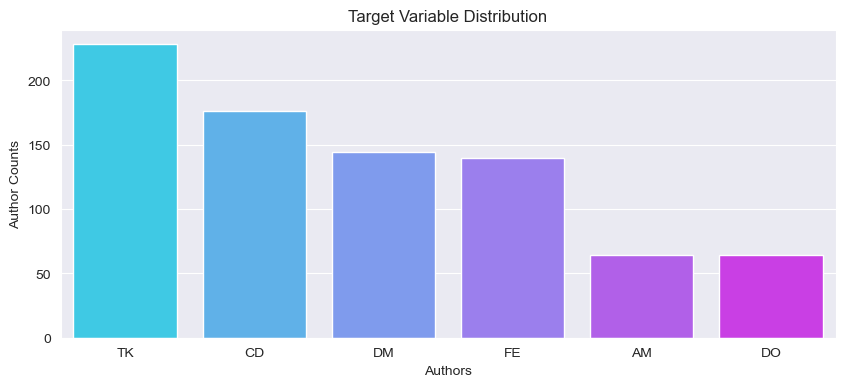

In [24]:
plt.figure(figsize=(10, 4))
sns.countplot(data=df_train, x="Author", order=df_train["Author"].value_counts().index, palette=palette);
plt.title("Target Variable Distribution");
plt.ylabel("Author Counts");
plt.xlabel("Authors");
plt.xticks();

<div class="alert alert-info" role="alert">
    Data is imbalanced. There are 2 ways that we can handle this: <br>
    1. Perform a combination of oversampling and undersampling techniques <br>
    2. Make use of a metric that accounts for the class imbalance. In our case we will look at the weighted average f1 score as it accounts for this.
</div>

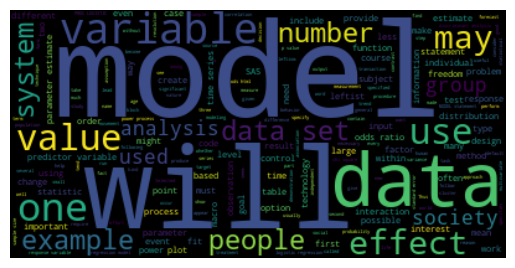

In [25]:
text = " ".join(df_train.Text)

wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<div class="alert alert-info" role="alert">
At first glance it can be seen that: 
    <br>
    -> Most important words: "Model", "Data", "Analysis", "Variable" <br>
    -> Stopwords: "One", "May", "Even", "Must"
</div>

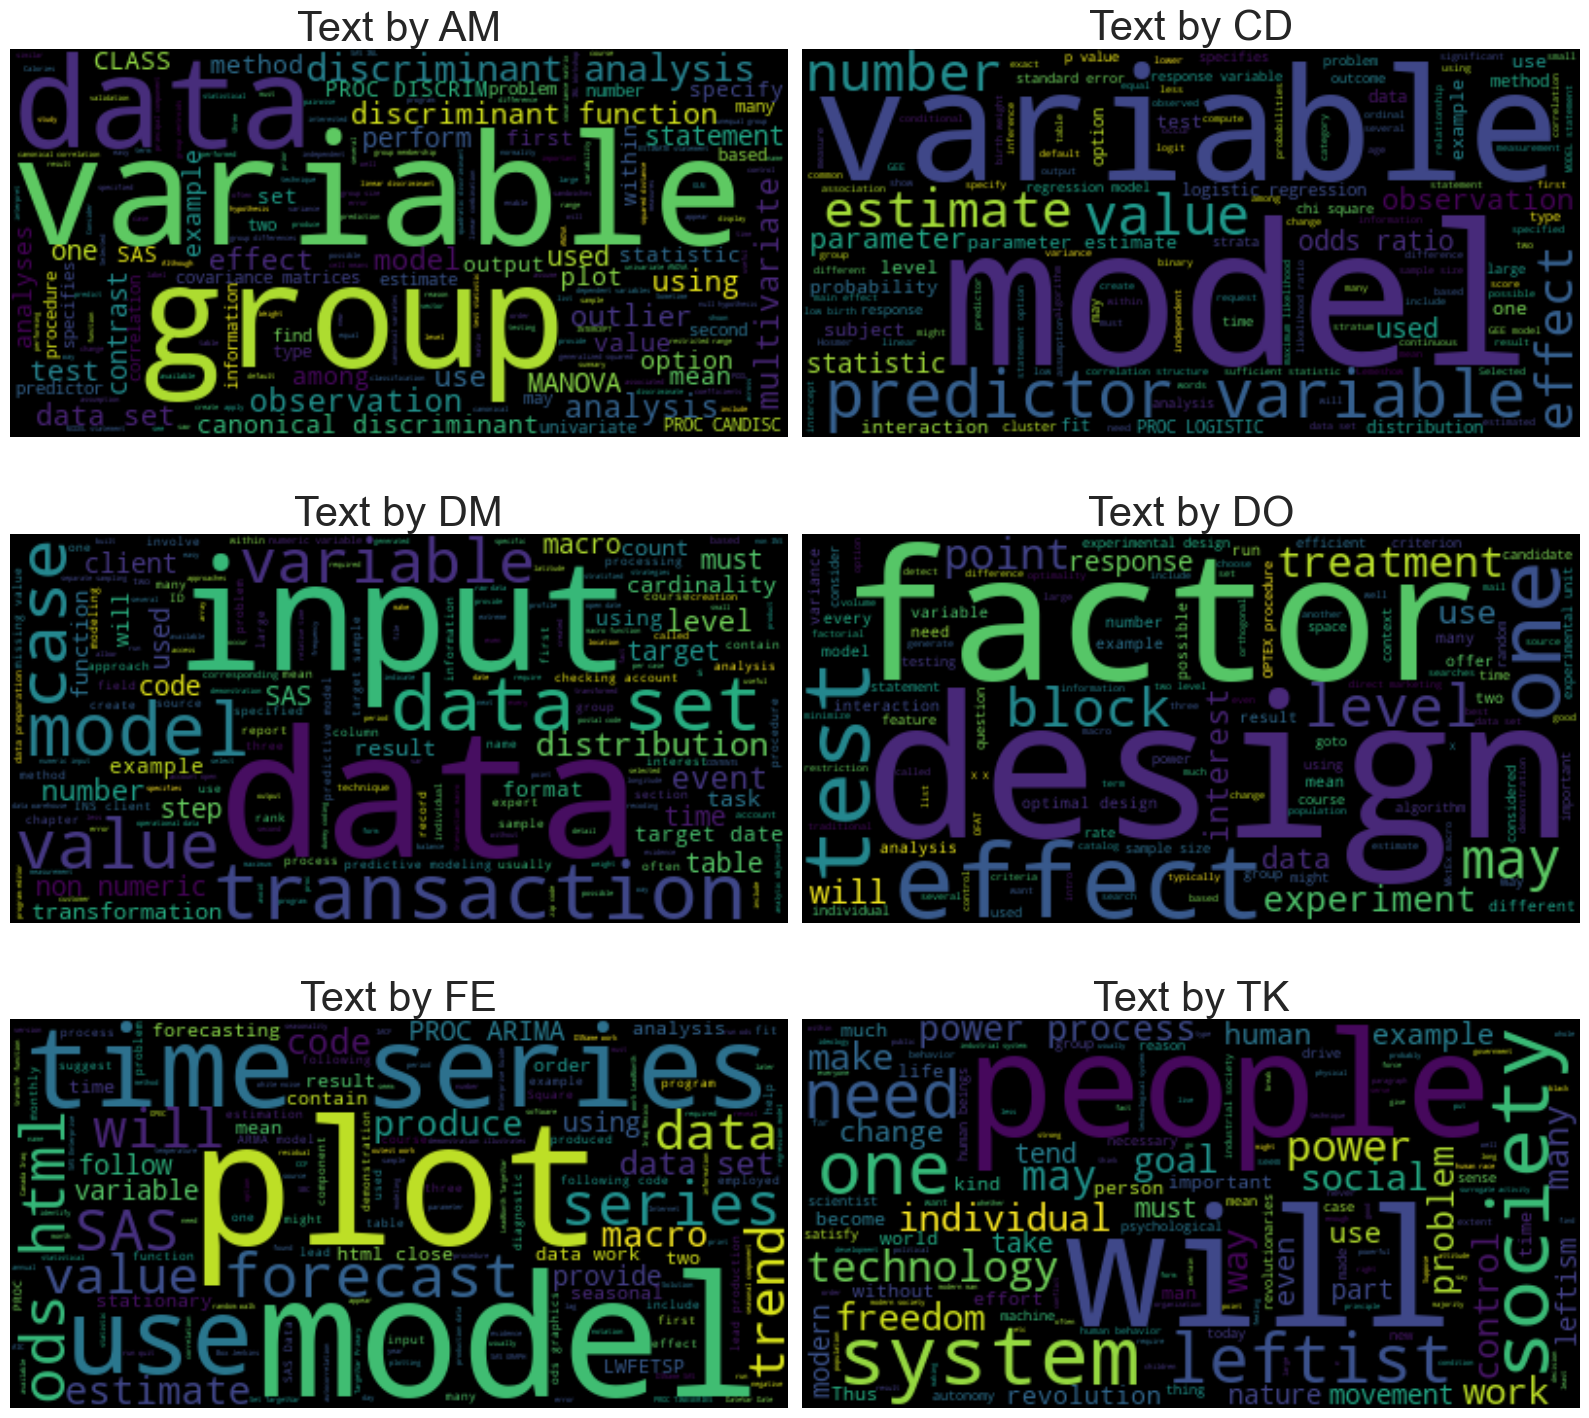

In [26]:
# look at words each author has written

author_texts = {author: " ".join(df_train[df_train['Author'] == author]['Text']) for author in df_train.Author.unique()} # all the texts written by author

num_authors = len(author_texts)
num_rows = num_authors // 2 + num_authors % 2

plt.figure(figsize=(16, 5 * num_rows)) # to show the wordclouds as subplots for easier viewing


for i, (author, text) in enumerate(author_texts.items(), start=1):
    wordcloud = WordCloud().generate(text)
    plt.subplot(num_rows, 2, i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Text by {author}", fontsize=30)
    plt.axis("off")
    
plt.tight_layout()
plt.show()

<div class="alert alert-info" role="alert">
At first glance it can be seen that each author is speaking about different topics: 
    <br>
    -> AM: talks about statistical classification techniques, discussing things such as discriminant analysis, group differences, and variable selection <br>
    -> CD: talks about machine learning and probability concepts like logistic regression, odds ratios, model estimation, predictor variable <br>
    -> DM: talks about data modeling, specifically addressing the management and analysis of transactional data sets <br>
    -> DO: talks about experimental design and topics like block design and factorial experiements <br>
    -> FE: talks about time series forecasting with topics like PROC, ARIMA and forecast <br>
    -> TK: talks about societal impact, with topics like society, psychological, and people.
</div>

## 4. Data Cleaning

In [27]:
x = 0
for i in df_train["Text"]:
    if "\\" in i:
        print(i)
        print("\n\n\n")
        
# some of the text also has file paths which are not required for the text
# these must be removed from the text as they are considered noise
# File names (xxxx.xx) must also be removed. 
# regex can be used to remove these texts. 

The Tofu Veg Delite does not appear to fit with the general pattern of the rest of the data. You also notice that the Frozen sandwiches are close to one another near the low end of Calories and Sodium. Principal Components and Outliers: SAS Code within the SAS/IML Workshop For more than three-dimensional space, the easiest way to spot outliers can be with a histogram of principal component scores. The program App_OutliersIML.iml is displayed below: libname amul 'C:\workshop\winsas\amul\data\';




Open the file Managing Data Pathologies 1.sas in the program editor. This general-purpose program creates a convenient statistical report on any SAS data set and places the report in a PDF file for review and printing. The report includes a CONTENTS procedure summary of the data set columns, statistical summaries and a distribution plot for every numeric variable, a cardinality report for every character variable, and a frequency table for every character variable with cardinality below a spe

In [28]:
# for the file paths the regex was created to start with any letter A - Z (capitalized or not) followed by :\\ and did not include a space
# or for the file names any non white space characters followed by a dot and one or more instances of non whitespace characters.

remove_file_paths = lambda text: re.sub(r'\b[A-Za-z]:\\[^ ]*|\S+\.\S+', '', text).strip()
remove_file_paths # creating lambda function for it

<function __main__.<lambda>(text)>

In [29]:
# preprocessing text and making them into tokens
def text_tokenizer(sent):
    lemmatizer = WordNetLemmatizer()
    sent = remove_file_paths(sent) # removing all file names and file paths
    sent = sent.lower() # text to lowercase
    sent_expand = contractions.fix(sent) # expand the contractions (I'd => I would)
    tokens = re.split(r'\W+', sent_expand) # split based on non word characters
    no_stopwords = [i for i in tokens if i not in stopwords.words('english')]
    clean_tokens = [
        lemmatizer.lemmatize(i) if i.lower() != "sas" else "SAS"
        for i in no_stopwords 
        if i not in string.punctuation 
        and not any(char.isdigit() for char in i)  # Check for digits
        and i != ""
    ]# remove number, punctuation, remove words with numbers and lemmatize text
    return clean_tokens



print(df_train["Text"].iloc[52])
print()
print(text_tokenizer(df_train["Text"].iloc[52])) # looking at the results

The Tofu Veg Delite does not appear to fit with the general pattern of the rest of the data. You also notice that the Frozen sandwiches are close to one another near the low end of Calories and Sodium. Principal Components and Outliers: SAS Code within the SAS/IML Workshop For more than three-dimensional space, the easiest way to spot outliers can be with a histogram of principal component scores. The program App_OutliersIML.iml is displayed below: libname amul 'C:\workshop\winsas\amul\data\';

['tofu', 'veg', 'delite', 'appear', 'fit', 'general', 'pattern', 'rest', 'data', 'also', 'notice', 'frozen', 'sandwich', 'close', 'one', 'another', 'near', 'low', 'end', 'calorie', 'sodium', 'principal', 'component', 'outlier', 'SAS', 'code', 'within', 'SAS', 'iml', 'workshop', 'three', 'dimensional', 'space', 'easiest', 'way', 'spot', 'outlier', 'histogram', 'principal', 'component', 'score', 'program', 'displayed', 'libname', 'amul']


In [30]:
df_train["cleaned_tokens"] = df_train["Text"].apply(text_tokenizer)
df_train.head()

,Text,Author,text_length,word_count,avg_word_length,type_to_token_ratio,punctuations_count,avg_sentence_length,POS_Nouns,POS_Verbs,flesch_reading_score,gunning_fog_index,unique_word_count,stopwords_number,cleaned_tokens
0,Scoring in PROC DISCRIM is as easy as validati...,AM,215,37,5.810811,0.840000,5,12.333333,0.305556,0.166667,58.99,10.33,21,12,"[scoring, proc, discrim, easy, validation, spe..."
1,"In the GLM procedure, you may have used LSMEAN...",AM,782,129,6.062016,0.661972,11,18.428571,0.286822,0.093023,52.80,11.39,47,59,"[glm, procedure, may, used, lsmeans, mean, sta..."
2,"The first problem, accuracy of the data file, ...",AM,990,159,6.226415,0.712766,19,16.000000,0.234177,0.158228,46.88,11.39,67,66,"[first, problem, accuracy, data, file, problem..."
3,If the homogeneity of covariance matrices assu...,AM,934,146,6.397260,0.604938,17,18.250000,0.312925,0.081633,44.44,11.98,49,69,"[homogeneity, covariance, matrix, assumption, ..."
4,"With a CONTRAST statement, you specify L, in t...",AM,1490,247,6.032389,0.488372,29,15.687500,0.282869,0.127490,55.54,9.15,63,122,"[contrast, statement, specify, l, case, vector..."


In [31]:
# these words with hyphens in the middle will be the compound words

pattern = re.compile(r'\b[A-Za-z]+(?:-[A-Za-z]+)+\b')

def find_words_hyphen(text):
    """
    finding all the words with hyphen and to make them as compound words when tokenizing
    """
    return pattern.findall(text)

hyphenated_words = df_train['Text'].apply(find_words_hyphen).sum()
hyphenated_words_flat = [''.join(word) for word in hyphenated_words]
hyphenated_word_counts = Counter(hyphenated_words_flat)
hyphenated_word_list = list(hyphenated_word_counts)

pprint(hyphenated_word_counts)

Counter({'chi-square': 33,
         'non-numeric': 28,
         'p-values': 22,
         'p-value': 16,
         'industrial-technological': 15,
         'small-scale': 13,
         'goodness-of-fit': 12,
         'Box-Jenkins': 12,
         'Breslow-Day': 11,
         'stratum-specific': 11,
         'non-INS': 11,
         'long-term': 10,
         'self-esteem': 10,
         'model-based': 9,
         'R-Square': 9,
         'subject-matter': 8,
         'case-control': 8,
         'SAS-Data-Set': 7,
         'power-hungry': 7,
         'so-called': 6,
         'higher-order': 6,
         'within-group': 5,
         'log-likelihood': 5,
         'Dickey-Fuller': 5,
         'organization-dependent': 5,
         'quasi-complete': 4,
         'two-factor': 4,
         'D-optimal': 4,
         'pre-whitening': 4,
         'Ljung-Box': 4,
         'black-style': 4,
         'long-distance': 4,
         'one-way': 3,
         'three-way': 3,
         'R-squared': 3,
         'Goodness-of

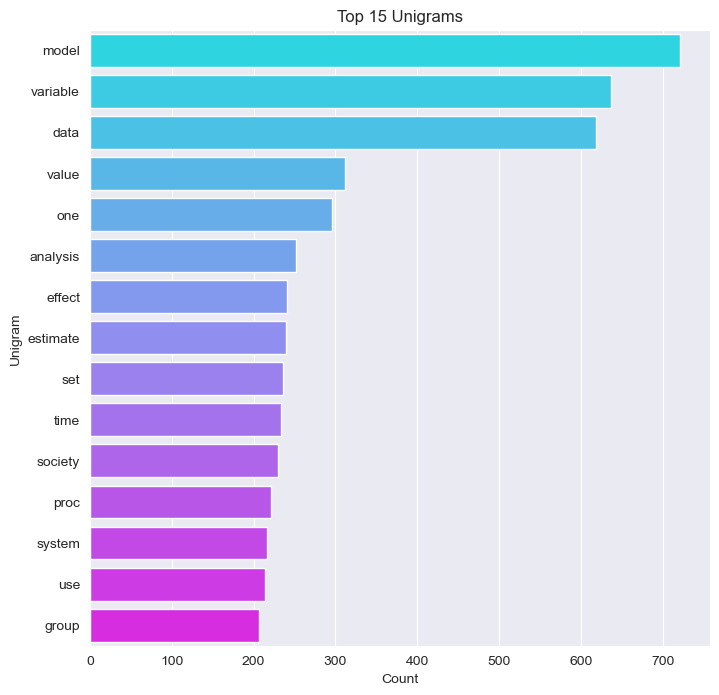

In [32]:
all_tokens = sum(df_train['cleaned_tokens'], [])
unigram_freq = FreqDist(all_tokens)

unigrams, counts = zip(*unigram_freq.most_common(15))
unigram_df = pd.DataFrame({'Unigram': unigrams, 'Count': counts})

plt.figure(figsize=(8, 8))
sns.barplot(x='Count', y='Unigram', data=unigram_df, order=unigram_df.sort_values('Count', ascending=False)['Unigram'], palette=palette)
plt.title('Top 15 Unigrams')
plt.show()

[(('data', 'set'), 172), (('predictor', 'variable'), 154), (('parameter', 'estimate'), 77), (('odds', 'ratio'), 70), (('time', 'series'), 69), (('logistic', 'regression'), 61), (('discriminant', 'analysis'), 54), (('regression', 'model'), 54), (('proc', 'logistic'), 54), (('response', 'variable'), 54)]


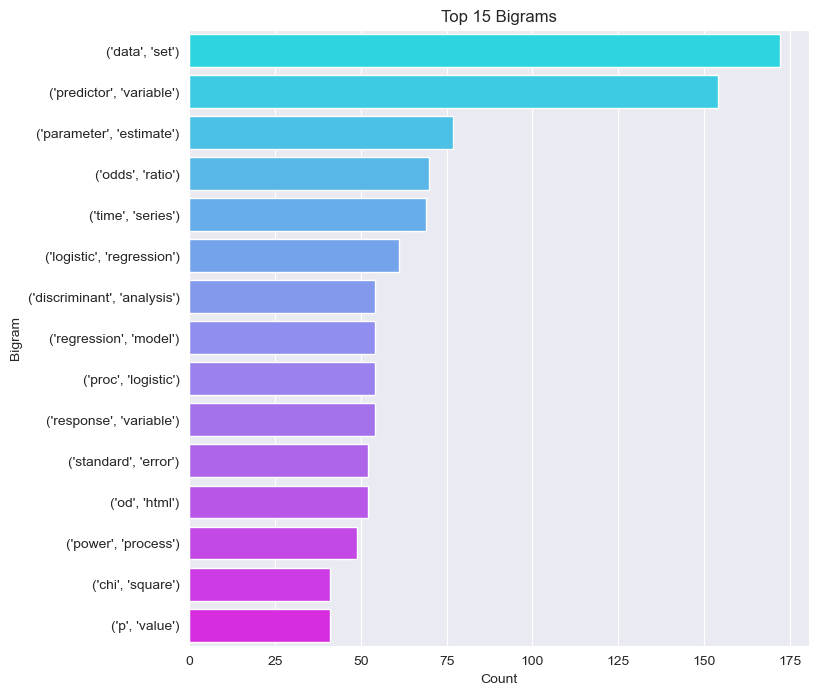

In [33]:
all_bigrams = list(bigrams(all_tokens))
bigram_freq = FreqDist(all_bigrams)
print(bigram_freq.most_common(10))

bigrams, counts = zip(*bigram_freq.most_common(15))
bigram_df = pd.DataFrame({'Bigram': bigrams, 'Count': counts})

plt.figure(figsize=(8, 8))
sns.barplot(x='Count', y='Bigram', data=bigram_df, order=bigram_df.sort_values('Count', ascending=False)['Bigram'], palette=palette)
plt.title('Top 15 Bigrams')
plt.show()

[(('logistic', 'regression', 'model'), 34), (('od', 'html', 'close'), 26), (('SAS', 'data', 'set'), 24), (('low', 'birth', 'weight'), 21), (('need', 'power', 'process'), 18), (('canonical', 'discriminant', 'analysis'), 17), (('data', 'set', 'contains'), 16), (('predictor', 'variable', 'value'), 14), (('pearson', 'chi', 'square'), 14), (('chi', 'square', 'statistic'), 13)]


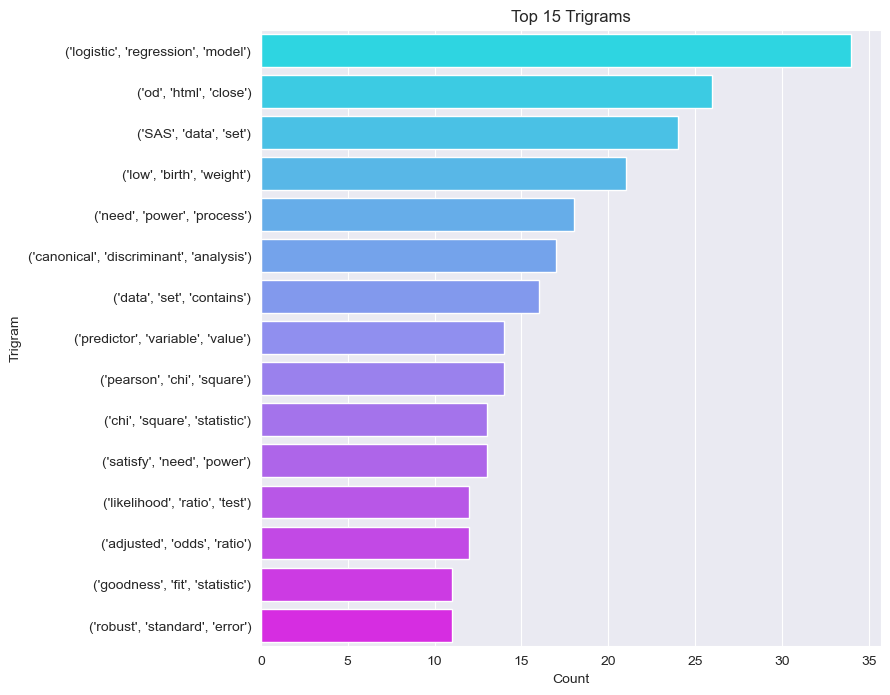

In [34]:
all_trigrams = list(trigrams(all_tokens))
trigram_freq = FreqDist(all_trigrams)
print(trigram_freq.most_common(10))

trigrams, counts = zip(*trigram_freq.most_common(15))
trigram_df = pd.DataFrame({'Trigram': trigrams, 'Count': counts})

plt.figure(figsize=(8, 8))
sns.barplot(x='Count', y='Trigram', data=trigram_df, order=trigram_df.sort_values('Count', ascending=False)['Trigram'], palette=palette)
plt.title('Top 15 Trigrams')
plt.show()

In [35]:
compound_words = [i[0] for i in bigram_freq.most_common(15)]
compound_words += [('logistic', 'regression', 'model')]

hyphenated_word_list = [i.split("-") for i in hyphenated_word_list]
compound_words += hyphenated_word_list
mwe_tokenizer = MWETokenizer(compound_words, separator="_")
mwe_tokenizer

In [36]:
# use this to update the tokens with compound words found from the bigram analysis
# also remove special characters and numbers
def apply_mwe_to_tokens(row):
    tokens = mwe_tokenizer.tokenize(row)
    cleaned_tokens = [token.replace('\t', '') for token in tokens if not token.isnumeric()]
    return cleaned_tokens

df_train['cleaned_tokens'] = df_train['cleaned_tokens'].apply(apply_mwe_to_tokens)
df_train.head()

,Text,Author,text_length,word_count,avg_word_length,type_to_token_ratio,punctuations_count,avg_sentence_length,POS_Nouns,POS_Verbs,flesch_reading_score,gunning_fog_index,unique_word_count,stopwords_number,cleaned_tokens
0,Scoring in PROC DISCRIM is as easy as validati...,AM,215,37,5.810811,0.840000,5,12.333333,0.305556,0.166667,58.99,10.33,21,12,"[scoring, proc, discrim, easy, validation, spe..."
1,"In the GLM procedure, you may have used LSMEAN...",AM,782,129,6.062016,0.661972,11,18.428571,0.286822,0.093023,52.80,11.39,47,59,"[glm, procedure, may, used, lsmeans, mean, sta..."
2,"The first problem, accuracy of the data file, ...",AM,990,159,6.226415,0.712766,19,16.000000,0.234177,0.158228,46.88,11.39,67,66,"[first, problem, accuracy, data, file, problem..."
3,If the homogeneity of covariance matrices assu...,AM,934,146,6.397260,0.604938,17,18.250000,0.312925,0.081633,44.44,11.98,49,69,"[homogeneity, covariance, matrix, assumption, ..."
4,"With a CONTRAST statement, you specify L, in t...",AM,1490,247,6.032389,0.488372,29,15.687500,0.282869,0.127490,55.54,9.15,63,122,"[contrast, statement, specify, l, case, vector..."


In [41]:
# lets save the tokenizer so the list of compound words dont have to be defined again
import pickle

with open('mwe_tokenizer.pkl', 'wb') as f:
    pickle.dump(mwe_tokenizer, f)

In [42]:
df_train.describe().T # summary statistics of all the features created
# easier to understand through visualization

,count,mean,std,min,25%,50%,75%,max
text_length,816.0,688.286765,532.106926,61.000000,304.000000,526.500000,922.000000,4096.000000
word_count,816.0,108.006127,84.159438,12.000000,47.000000,81.000000,147.000000,704.000000
avg_word_length,816.0,6.429311,0.597206,5.000000,6.056834,6.349312,6.710606,10.937500
type_to_token_ratio,816.0,0.767340,0.117589,0.376963,0.690234,0.770330,0.848485,1.000000
punctuations_count,816.0,16.705882,15.819899,1.000000,6.000000,12.000000,22.000000,155.000000
avg_sentence_length,816.0,16.911385,5.650943,4.500000,13.000000,16.333333,20.000000,41.833333
POS_Nouns,816.0,0.285110,0.071083,0.054054,0.234565,0.278879,0.327948,0.636364
POS_Verbs,816.0,0.117164,0.037620,0.000000,0.093562,0.116586,0.139535,0.266667
flesch_reading_score,816.0,43.933051,13.594932,-10.420000,35.940000,44.240000,52.800000,83.360000
gunning_fog_index,816.0,13.193885,3.155677,5.150000,11.167500,12.725000,14.852500,29.270000


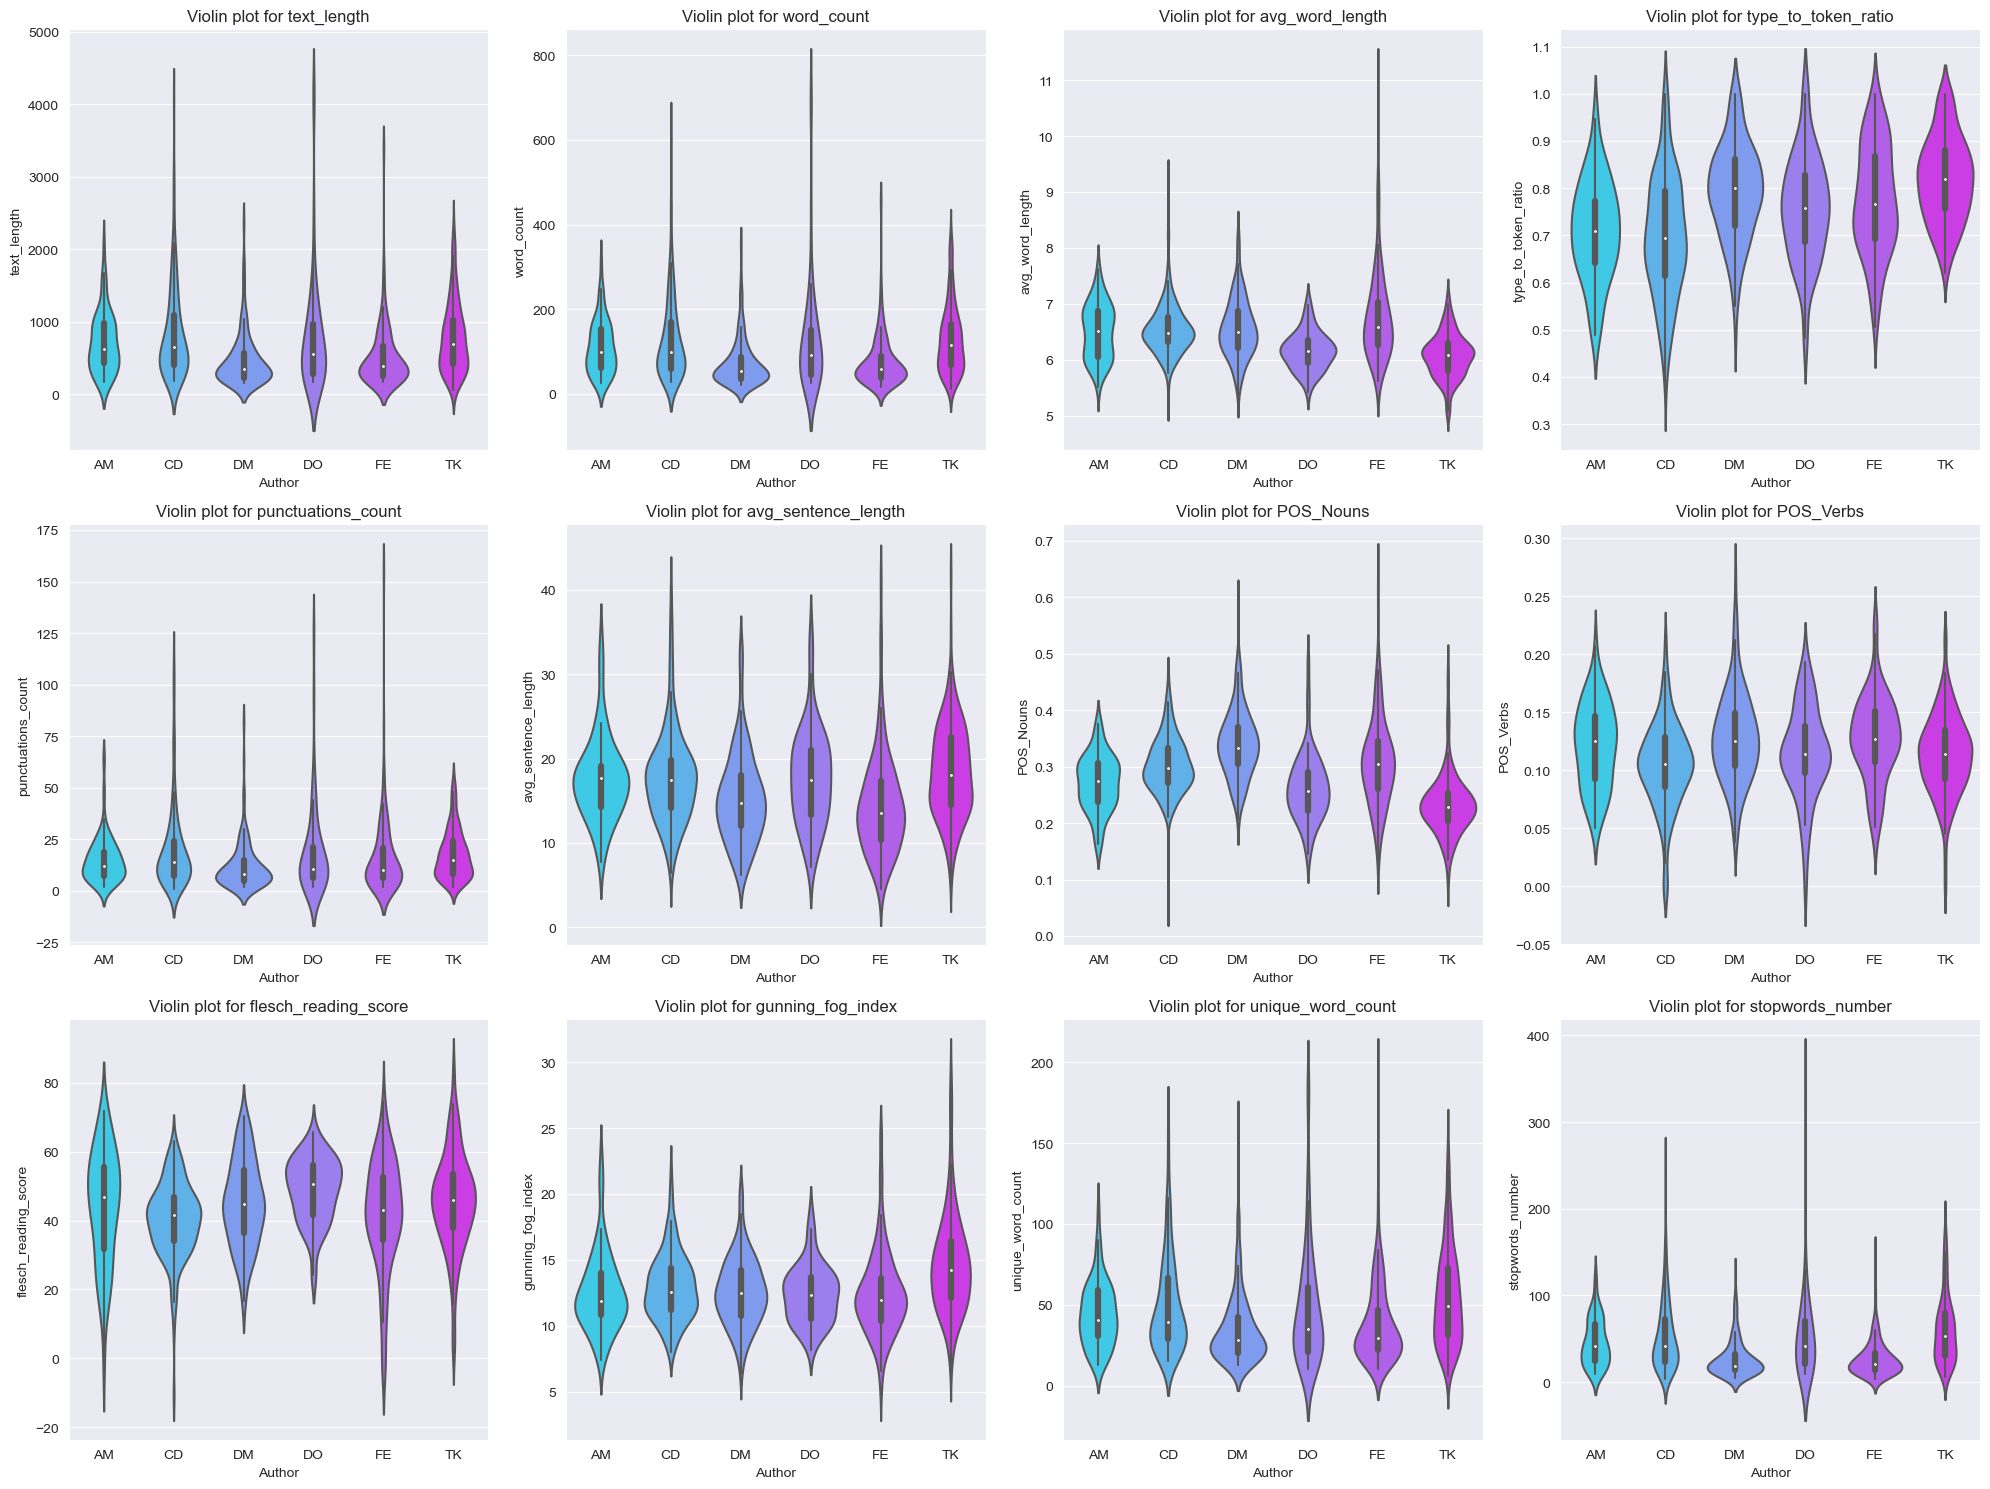

In [43]:
col_names = df_train.describe().columns
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

axes = axes.flatten()

for i, col in enumerate(col_names):
    sns.violinplot(x="Author", y=col, data=df_train, ax=axes[i], palette=palette)
    axes[i].set_title(f'Violin plot for {col}')

plt.tight_layout()
plt.show()

<div class="alert alert-info" role="alert">
--> Each author has unique features present, which could be useful in differentiating the writing styles <br>
--> Text Lengths and word counts: Authors like CD and DO tend to write longer texts while AM and TK write shorter texts <br>
--> However on average, FE uses longer words as compared to the other authors <br>
--> For word diversity, indicated through the type to token ratio, TK has more diverse text as compared to the other authors, while CD has a larger range for the type to token ratio <br>
--> The authors have similar number of punctuations however DM has a slightly lower count than the rest and TK has a slightly higher count <br>
--> FE has the lowest average sentence length while TK has the highest. <br>
--> TK has the lowest proportion of nouns used in the text while DM has the highest. <br>
--> All authors have a similar proportion of verbs used within the median between 0.10 and 0.15 <br>
--> Flesch reading score shows the readability of the text and it seems that DO and AM having a wider readability distribution of around 60. This means that the text which is more readable is more likely to be of these authors. <br>
--> Gunning fog talks about the complexity of the text, and in this case TK and DO have the highest complexity in their texts.<br>
--> DO and FE show a wider range and higher median in unique word count, indicating a more diverse vocabulary.<br>
--> DO and FE have a higher median number of stopwords, which could suggest longer texts or a writing style that uses more common language.
</div>

In [44]:
df_train.to_csv("cleaned_data.csv")